## Flood Vulnerability Index (FVI) Assessment and Mapping

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# UPAZILA SHAPEFILE
# ------------------------------------------------- #
shape = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape.loc[shape['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape.loc[shape['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape['ADM3_PCODE'] = shape['ADM3_PCODE'].astype(int)
# with fiona.open('./data/adm_upazila.shp', "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]
# ------------------------------------------------- #

In [2]:
# Load data
data = pd.read_hdf('./data/data.hdf')
data_dist = pd.read_hdf('./data/data_dist.hdf')
data_table = pd.read_hdf('./data/data_table.hdf')
# Add a dot to the district variables
name_dot = data_table['Name'].copy()
name_dot[data_table['Scale'] == "District"] = name_dot[data_table['Scale'] == "District"] + '*'

# Label short names
data_table_temp = data_table.copy()
data_table_temp['Domain'] = data_table_temp['Domain'].replace({'Demographic':'DEMO', 
                                                               'Health':'HEALTH',
                                                               'Social':'SOCIAL',
                                                               'Adaptive Capacity':'ADAPT CAPACITY',
                                                               'Economic':'ECON',
                                                               'Built':'BUILT'})
data = data[data_table['Name']]

# Re-group to three groups
data_table['Domain'] = data_table['Domain'].replace({'Demographic':'SOCIO-ECONOMIC', 
                                                     'Built':'SOCIO-ECONOMIC', 
                                                     'Social':'SOCIO-ECONOMIC',
                                                     'Economic':'SOCIO-ECONOMIC',
                                                     'Health':'HEALTH',
                                                     'Adaptive Capacity':'ADAPT CAPACITY'})
domains = data_table['Domain'].unique()
ndm = len(domains)
nvar = np.array([(data_table['Domain'] == dm).sum() for dm in domains])
ndist = data.shape[0]

### Correlation Matrix

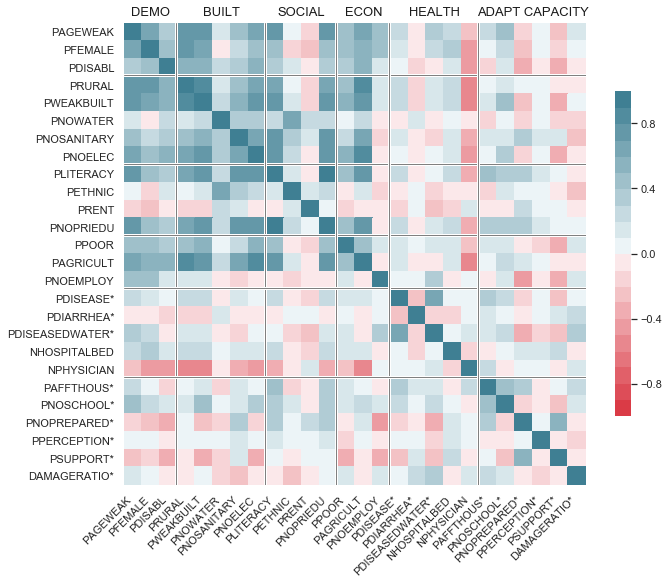

In [3]:
# Correlation Matrix
corrmat = data.corr()
corrmat_dist = data_dist.corr()
index = data_table[data_table['Scale'] == 'District'].index
# - Replace Upazila correaltions to District correlation for district-level variables
corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
# - Replace name_dot
corrmat.columns = name_dot; corrmat.index = name_dot
corrmat.index.name = ''
corrmat.columns.name = ''


# Plotting
sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 220, n=20)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-1, vmax=1, center=0,
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5})

# Domains
# domain_name = ['DEMO','HEAL','SOCIO-ECON']
sources = data_table_temp['Domain'].tolist()
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        # Domain lines
        ax.axhline(i-0.05, c="w", lw=3)
        ax.axhline(i-0.05, c="grey", lw=1)
        ax.axvline(i-0.05, c="w", lw=3)
        ax.axvline(i-0.05, c="grey", lw=1)
    if source != sources[i - 1]:
        # Domain names
        lx = np.arange(len(corrmat))[np.isin(sources, source)]
        ax.annotate(source, [np.median(lx)+0.5, -0.4], 
                    xycoords='data', annotation_clip=False,
                    color='k', ha='center', fontfamily='sans-serif', fontsize=13)

ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.tight_layout()
plt.show()

# Save a figure
if False:
    fn_save = './figures/corrmat.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### PCA analysis
Here, we reduce the dimensions of the three groups: Socio-economic (DEMO, BUILT, SOCIAL, ECONOMIC), Health, and Adaptive capacity.

In [5]:
# # PCA Analysis
# # We apply the PCA analysis to each domain group to obtain uncorrelated principal components.
# # As a rule of thumb, PCs are truncated when a cumulative sum of eigenvalues is greater than 70%.
# threshold = 0.7
# scores = []
# evalratio = []
# components = []
# for dm in domains:
#     subdata = data[data_table.loc[data_table['Domain'] == dm, 'Name']]
#     zsubdata = StandardScaler().fit_transform(subdata)
#     # PCA
#     pca = decomposition.PCA(n_components=zsubdata.shape[1],
#                             whiten=False,
#                             svd_solver='full')
#     pca.fit(zsubdata)
#     # Truncate data with threshold
#     cut = np.argwhere(pca.explained_variance_ratio_.cumsum() > threshold)[0][0]+1
#     # Save variables
#     scores.append(pca.transform(zsubdata)[:,:cut])
#     evalratio.append(pca.explained_variance_ratio_.cumsum())
#     components.append(pca.components_[:,:cut])


# SoVI with varimax rotation
sovi_domain = np.zeros([ndist,ndm])
for i, dm in enumerate(domains):
    subdata = data[data_table.loc[data_table['Domain'] == dm, 'Name']]
    zsubdata = StandardScaler().fit_transform(subdata)
    # PCA
    pca = fhv.SPSS_PCA(subdata, reduce=True, varimax=True)
    sovi_domain[:,i] = pca.scores_rot.sum(1)

### Mapping Principal Components

In [8]:
pca.scores_rot

array([[-2.25671647,  0.05629859, -1.31708426],
       [-2.25671647,  0.05629859, -1.31708426],
       [-2.25671647,  0.05629859, -1.31708426],
       ...,
       [ 0.51793214,  0.31432326, -0.14178899],
       [ 0.51793214,  0.31432326, -0.14178899],
       [ 0.51793214,  0.31432326, -0.14178899]])

### Vulnerability Assessments
- (a) Equal weights
- (b) Random weights
- (c) Domain PCAs with equal weights

In [16]:
# Empty vulnerability dataframe
vuln = pd.DataFrame(index=data.index.astype('int'))

# (a) Equal weights
vuln_equal = np.zeros([data.shape[0],ndm])
for i, dm in enumerate(domains):
    target = data_table['Domain'] == dm
    ewgt = 1/ndm/target.sum()
    vuln_equal[:,i] = np.dot(data[data_table[target].Name], np.full([target.sum(),1],ewgt)).flatten()
vuln['equal'] = QuantileTransformer(ndist).fit_transform(vuln_equal).sum(1)/3


# (b) Random weights
# Sensitivity analysis with random weights
nt = 1000      # Must be a multiple of 100
thsd = 0.70    # Values over this threshold are counted
freq = np.zeros([data.shape[0],1])
data1 = data[data_table[data_table['Domain'] == domains[0]].Name]
data2 = data[data_table[data_table['Domain'] == domains[1]].Name]
data3 = data[data_table[data_table['Domain'] == domains[2]].Name]
for i in range(nt//100):
    rwgt1 = np.random.random([nvar[0],100])
    rwgt1 = rwgt1/rwgt1.sum(axis=0)
    rwgt2 = np.random.random([nvar[1],100])
    rwgt2 = rwgt2/rwgt2.sum(axis=0)
    rwgt3 = np.random.random([nvar[2],100])
    rwgt3 = rwgt3/rwgt3.sum(axis=0)
    vuln_rand1 = QuantileTransformer(n_quantiles=ndist).fit_transform(np.dot(data1,rwgt1))
    vuln_rand2 = QuantileTransformer(n_quantiles=ndist).fit_transform(np.dot(data2,rwgt2))
    vuln_rand3 = QuantileTransformer(n_quantiles=ndist).fit_transform(np.dot(data3,rwgt3))
    vuln_rand = (vuln_rand1 + vuln_rand2 + vuln_rand3)/3
    freq += (vuln_rand > thsd).sum(1)[:,None]
vuln['random'] = freq/nt


# (c) Domain PCAs with equal weights
# Domain-level Scores
score_domain = np.array([score.sum(1) for score in scores]).T
score_domain_scaled = QuantileTransformer(n_quantiles=ndist).fit_transform(score_domain)
vuln['pca_eq'] = score_domain_scaled.sum(1)/score_domain_scaled.shape[1]


# (d) Domain SoVIs
# sovi_domain_scaled = MinMaxScaler().fit_transform(sovi_domain)
sovi_domain_scaled = QuantileTransformer(n_quantiles=10).fit_transform(sovi_domain)
vuln['sovi'] = sovi_domain_scaled.sum(1)/ndm


# Merge all vulnerabilities
map_upazila = pd.merge(shape, vuln, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

### Mapping Vulnerabilities

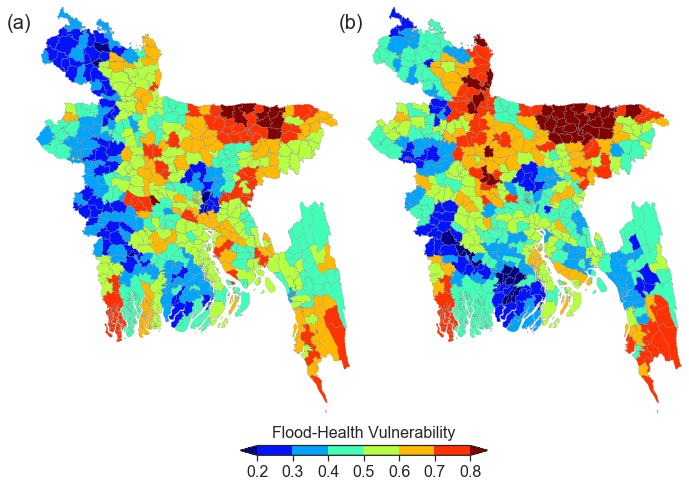

./figures/vulnerability.png is saved.


In [29]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Flood-Health Vulnerability'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,5), facecolor='w')
for (i, el) in enumerate(['sovi','equal']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_upazila.plot(ax=ax, column=el, 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.05, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.4, -0.1, 1.7, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Load FFWC Flood Forecast issued at Aug-16, 2017

In [19]:
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1)  # Flood depth (decuple)
# fcst = np.array(fcst >= 20).astype(np.int8).flatten()


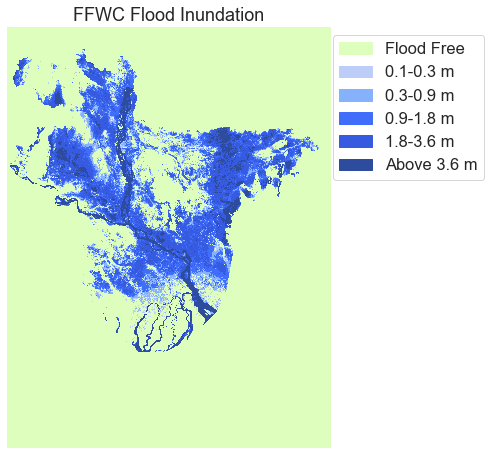

In [23]:
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import seaborn as sns
import fiona
from descartes import PolygonPatch
sns.set(font_scale=1.5, style="white")


## TODO: Overlay shapefile on the raster map



# Define the colors
class_bin = np.array([0,1.01,3,9,18,36,100])
class_label = ['Flood Free','0.1-0.3 m','0.3-0.9 m','0.9-1.8 m','1.8-3.6 m','Above 3.6 m']
class_rgb = [[222,254,190],[188,205,247],[134,177,252],[65,109,251],[54,91,224],[45,76,157]]
class_rgb = list(np.array(class_rgb)/255)
cmap = ListedColormap(class_rgb)
cmap.name = class_label
# Define a normalization from values -> colors
norm = colors.BoundaryNorm(class_bin, len(class_bin))

# Plot raster
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7), facecolor='w')
im = ax.imshow(fcst,cmap=cmap,norm=norm)
# Title
ax.set_title("FFWC Flood Inundation")
# Legend
patches = [ mpatches.Patch(color=class_rgb[i],label=class_label[i]) for i in range(len(class_label)) ]
ax.legend(handles=patches,bbox_to_anchor=(1.5, 1),facecolor="white")
# Post-setting
plt.tight_layout()
ax.set_axis_off()
plt.show()

### Join 2017 FFWC Flood Forecast to Flood-Health Vulnerability

In [145]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()              # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()  # Population Per Pixel (Decuple value)
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple)

In [147]:
# Affected population by Flood Inundation and Flood Forecast
# - Flood Inundation
popuInun = popu.copy()
popuInun[inun == 0] = 0       # Population in both Perennial water and Flood inundation
popuInun[inun != 2] = 0       # Population in Flood inundation
# - Flood Forecast
popuFcst = popu.copy()
popuFcst[fcst < 30] = 0       # Population in Flood depth (>= 1.0m)

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

In [150]:
# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POPU_TOTAL'], impact4['POPU_INUN'], impact4['POPU_FCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPU_INUN_RATIO'] = afftPopuInun/totlPopu
impact4['POPU_FCST_RATIO'] = afftPopuFcst/totlPopu
impact4['CELL_TOTAL'], impact4['CELL_INUN'], impact4['CELL_FCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELL_INUN_RATIO'] = afftCellInun/totlCell
impact4['CELL_FCST_RATIO'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POPU_TOTAL','POPU_INUN','POPU_FCST','CELL_TOTAL','CELL_INUN','CELL_FCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPU_INUN_RATIO'] = impact3['POPU_INUN']/impact3['POPU_TOTAL']
impact3['POPU_FCST_RATIO'] = impact3['POPU_FCST']/impact3['POPU_TOTAL']
impact3['CELL_INUN_RATIO'] = impact3['CELL_INUN']/impact3['CELL_TOTAL']
impact3['CELL_FCST_RATIO'] = impact3['CELL_FCST']/impact3['CELL_TOTAL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values
# Aggregate to District level
impact2 = impact3.groupby(['ADM2_PCODE', 'ADM2_EN'])[varlist].sum()
impact2['POPU_INUN_RATIO'] = impact2['POPU_INUN']/impact2['POPU_TOTAL']
impact2['POPU_FCST_RATIO'] = impact2['POPU_FCST']/impact2['POPU_TOTAL']
impact2['CELL_INUN_RATIO'] = impact2['CELL_INUN']/impact2['CELL_TOTAL']
impact2['CELL_FCST_RATIO'] = impact2['CELL_FCST']/impact2['CELL_TOTAL']
impact2['ADM1_PCODE'], impact2['ADM1_EN'] = shp_district['ADM1_PCODE'].values, shp_district['ADM1_EN'].values

# Print
print('TOTAL_POPU_INUN: {:,}'.format(impact4['POPU_INUN'].sum().astype(int)))
print('TOTAL_POPU_FCST: {:,}'.format(impact4['POPU_FCST'].sum().astype(int)))

# Merge with shapefiles
varlist.extend(['POPU_INUN_RATIO', 'POPU_FCST_RATIO', 'CELL_INUN_RATIO', 'CELL_FCST_RATIO'])
map_union = shp_union.merge(impact4, on='ADM4_PCODE')
map_upazila = shp_upazila.merge(impact3[varlist], on='ADM3_PCODE')
map_district = shp_district.merge(impact2[varlist], on='ADM2_PCODE')

TOTAL_POPU_INUN: 19,642,620
TOTAL_POPU_FCST: 10,063,213


In [173]:
# impact3.merge(vuln,on='ADM3_PCODE')
temp = impact3.reset_index(drop=False).set_index('ADM3_PCODE')
temp.index = temp.index.astype(int)
temp = temp.merge(vuln, on='ADM3_PCODE')
temp['POPU_TOTAL'].sum()

146666345.60000002